# **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [165]:
# импорт библиотек
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [18]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# группируем
timestamp_of_data_min=data.groupby(['group'])['date'].agg('min')
timestamp_of_data_max=data.groupby(['group'])['date'].agg('max')
display(timestamp_of_data_min,timestamp_of_data_max)


group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [27]:
# суммарное количество посещений
user_visits=data.groupby(['group'])['user_id'].agg('count')
display(user_visits)

# суммарное количество покупок
purchases_amount=data.groupby(['group'])['purchase'].agg('sum')
display(purchases_amount)

# сумма покупок
purchases_amount=data.groupby(['group'])['price'].agg('sum')
display(purchases_amount)

group
A    147202
B    147276
Name: user_id, dtype: int64

group
A    17723
B    17514
Name: purchase, dtype: int64

group
A    1436260000
B    1554100000
Name: price, dtype: int64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0.

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [33]:
# создаём множества, пересекаем их и выводим длину получившегося множества
users_A = set(data[data['group']=='A']['user_id'])
users_B = set(data[data['group']=='B']['user_id'])
user_intersection = users_A & users_B
print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [35]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.3+ MB


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

| group | count_visits | count_purchases | sum_price |
| --- | --- | --- | --- |
| A | ? | ? | ? |
| B | ? | ? | ? |
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?

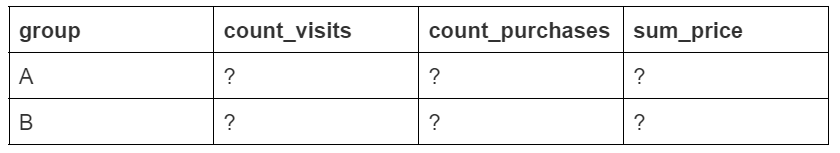

In [37]:
prepared_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits','purchase': 'count_purchases','price': 'sum_price',})
prepared_data.head()

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

**ВЫВОД 7.5**  
Количество посещений по группам выглядит сбалансированнно (пользователи, посетившие сайт от обеих групп были удалены, и разница в количестве посещений изменилась приблизительно одинаково).  
На текущем этапе прослеживается необходимость в выявлении приоритетного признака для оценки конверсии, так как разница в количестве покупок компенсируется разницей в сумме этих покупок (например, в группе А больше покупок, но меньше их сумма).
***

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [59]:
prepared_data['conversion'] = prepared_data['count_purchases']/prepared_data['count_visits']*100
prepared_data['mean_check'] = prepared_data['sum_price']/prepared_data['count_purchases']
display(prepared_data)

conv_A = prepared_data[prepared_data['group']=='A']['conversion'].round(2)
conv_B = prepared_data[prepared_data['group']=='B']['conversion'].round(2)
check_A = prepared_data[prepared_data['group']=='A']['mean_check'].round(0)
check_B = prepared_data[prepared_data['group']=='B']['mean_check'].round(0)
display(conv_A)
display(conv_B)
display(check_A)
display(check_B)

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


0    12.03
Name: conversion, dtype: float64

1    11.89
Name: conversion, dtype: float64

0    81076.0
Name: mean_check, dtype: float64

1    88665.0
Name: mean_check, dtype: float64

Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

**ВЫВОДЫ 7.6**

Вариант А имеет более высокую конверсию, но менее высокий средний чек.
***

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

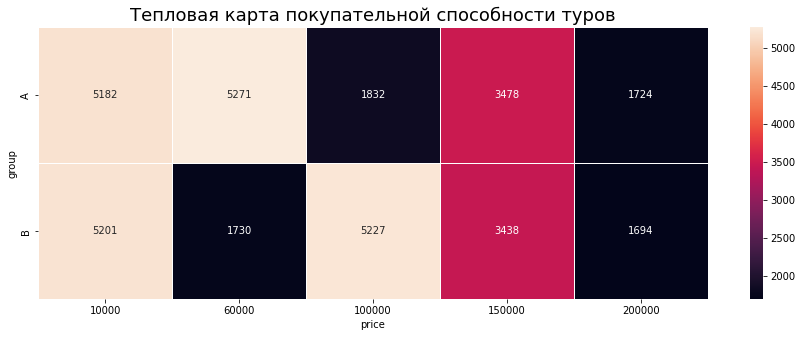

In [115]:
heat_pivot = updated_data.pivot_table(index='group', columns='price', values='purchase', aggfunc='sum', fill_value=0)
heat_pivot.drop(columns=0, inplace=True)
fig, ax = plt.subplots(figsize=(15,5))
heatmap = sns.heatmap(data=heat_pivot, annot = True, fmt='d',linewidths=.5, ax=ax)
heatmap.set_title('Тепловая карта покупательной способности туров', fontsize=18);

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [120]:
print(heat_pivot[60000]["A"])
print(heat_pivot[60000]["B"])

5271
1730


Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

**ВЫВОДЫ**

Пользователи из группы А гораздо чаще покупают туры за 60, чем за 100 тысяч рублей, ситуация в группе В - обратная. Остальные продажи в группах отличаются незначительно.
***

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [139]:
# заново группируем данные
cum_data = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits','purchase': 'count_purchases','price': 'sum_price',})

# добавляем столбцы с конверсией и средним чеком
cum_data['conversion'] = cum_data['count_purchases']/cum_data['count_visits']*100
cum_data['check'] = cum_data['sum_price']/cum_data['count_purchases']

display(cum_data.head(10))

display(cum_data[cum_data['date']=='2021-01-03']['conversion'].round(2))
display(cum_data[cum_data['date']=='2021-01-03']['check'].round(0))

,date,group,count_visits,count_purchases,sum_price,conversion,check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270
5,2021-01-04,B,6536,764,68030000,11.689106,89044.502618
6,2021-01-05,A,6433,790,64550000,12.280429,81708.860759
7,2021-01-05,B,6511,749,63550000,11.503609,84846.461949
8,2021-01-06,A,6606,764,63410000,11.565244,82997.382199
9,2021-01-06,B,6751,838,75020000,12.412976,89522.673031


2    11.34
3    11.39
Name: conversion, dtype: float64

2    82888.0
3    87480.0
Name: check, dtype: float64

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [143]:
# Собираем группу А отдельно
cum_data_a = cum_data[cum_data['group'] == 'A']
# считаем кумулятивные метрики для А
cum_data_a.loc[:, 'cum_count_visits'] = cum_data_a['count_visits'].cumsum();
cum_data_a.loc[:, 'cum_count_purchases'] = cum_data_a['count_purchases'].cumsum();
cum_data_a.loc[:, 'cum_sum_price'] = cum_data_a['sum_price'].cumsum();
cum_data_a['cum_conversion'] = cum_data_a['cum_count_purchases']/cum_data_a['cum_count_visits']*100
cum_data_a['cum_check'] = cum_data_a['cum_sum_price']/cum_data_a['cum_count_purchases']

# Собираем группу В отдельно
cum_data_b = cum_data[cum_data['group'] == 'B']
# считаем кумулятивные метрики для В
cum_data_b.loc[:, 'cum_count_visits'] = cum_data_b['count_visits'].cumsum();
cum_data_b.loc[:, 'cum_count_purchases'] = cum_data_b['count_purchases'].cumsum();
cum_data_b.loc[:, 'cum_sum_price'] = cum_data_b['sum_price'].cumsum();
cum_data_b['cum_conversion'] = cum_data_b['cum_count_purchases']/cum_data_b['cum_count_visits']*100
cum_data_b['cum_check'] = cum_data_b['cum_sum_price']/cum_data_b['cum_count_purchases']

# кумулятивная конверсия на 20 января 2021 в группе В
display(cum_data_b[cum_data_b['date']=='2021-01-20']['cum_conversion'].round(2))
# кумулятивный средний чек на 12 января 2021 в группе А
display(cum_data_a[cum_data_a['date']=='2021-01-12']['cum_check'].round(0))

C:\Users\Роман\AppData\Local\Temp\ipykernel_62348\2032113300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cum_data_a.loc[:, 'cum_count_visits'] = cum_data_a['count_visits'].cumsum();
C:\Users\Роман\AppData\Local\Temp\ipykernel_62348\2032113300.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cum_data_a.loc[:, 'cum_count_purchases'] = cum_data_a['count_purchases'].cumsum();
C:\Users\Роман\AppData\Local\Temp\ipykernel_62348\2032113300.py:6: SettingWithCopyWarning: 
A value is trying to be set on a c

37    11.9
Name: cum_conversion, dtype: float64

20    81492.0
Name: cum_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

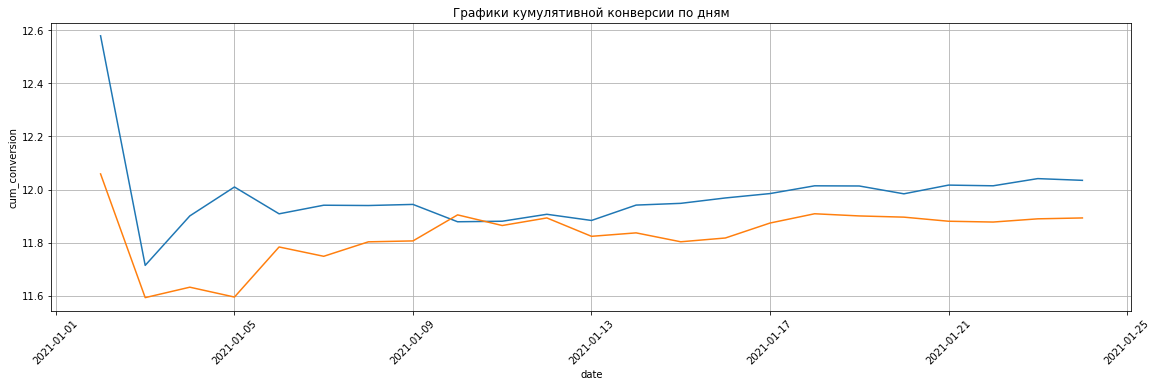

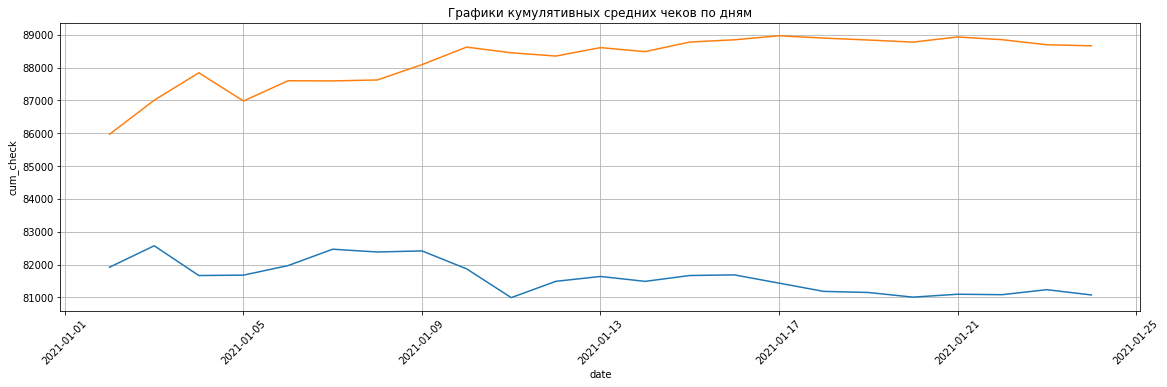

In [151]:
# создаём фигуру размером 8x4
fig1 = plt.figure(figsize=(15, 4))
# добавляем систему координат
ax = fig1.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=cum_data_a, ax=ax)
sns.lineplot(x='date', y='cum_conversion', data=cum_data_b, ax=ax)
# задаём подпись к графику
ax.set_title('Графики кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

# создаём фигуру размером 8x4
fig2 = plt.figure(figsize=(15, 4))
# добавляем систему координат
ax = fig2.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_check', data=cum_data_a, ax=ax)
sns.lineplot(x='date', y='cum_check', data=cum_data_b, ax=ax)
# задаём подпись к графику
ax.set_title('Графики кумулятивных средних чеков по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

**ВЫВОДЫ 7.9**

График кумулятивной конверсии говорит о стабилизации метрики по группам примерно после 10 января. Конверсия в группе В стабильно ниже, чем в А, однако разница в конверсии не выглядит значимой (0.2 %).  
Графики кумулятивных средних чеков показывают более информативную картину: кум. ср. чек в группе В стабильно выше, чем в группе А, что говорит о большей эффективности продаж при незначительно меньшей конверсии.
***

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [159]:
# объединение датафреймов для дальнейшей работы
cum_data = pd.concat([cum_data_a,cum_data_b]).reset_index()
cum_data.drop(cum_data.columns[[0]], axis=1, inplace=True)
cum_data.head(3)
# создание группированной таблицы для получения количества 'успехов' и 'наблюдений'
converted_cum_data = cum_data.groupby('group')['count_purchases','count_visits'].sum()
display(converted_cum_data)

C:\Users\Роман\AppData\Local\Temp\ipykernel_62348\2071585365.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  converted_cum_data = cum_data.groupby('group')['count_purchases','count_visits'].sum()


,count_purchases,count_visits
group,,
A,17487,145307
B,17290,145381


In [160]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_cum_data['count_purchases'],
    nobs=converted_cum_data['count_visits'],
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу, что {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

**ВЫВОДЫ**

Конверсии в группах А и В равны и статитстической разницы между ними нет.
***

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [171]:
# функция поиска границ доверительного интервала
def proportions_conf_interval(n, x_p, rnd=2, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, rnd), round(upper_bound * 100, rnd)

# функция поиска границ доверительного интервала для разницы конверсий
def diff_proportions_conf_interval(n, xp, rnd=2, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, rnd), round(upper_bound * 100, rnd)

In [172]:
conf_interval_a = proportions_conf_interval(
n=updated_data[updated_data['group']=='A']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group']=='A']['purchase'].mean() # выборочная пропорция
)

conf_interval_b = proportions_conf_interval(
n=updated_data[updated_data['group']=='B']['user_id'].count(), # размер выборки
x_p=updated_data[updated_data['group']=='B']['purchase'].mean() # выборочная пропорция
)

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

# размеры выборок групп А и B
n = [updated_data[updated_data['group']=='A']['user_id'].count(), updated_data[updated_data['group']=='B']['user_id'].count()]
# выборочная пропорция групп A и B
xp = [updated_data[updated_data['group']=='A']['purchase'].mean(), updated_data[updated_data['group']=='B']['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 